In [16]:
import os
import numpy as np
import galsim
from galsim import roman
from romanisim import image, parameters, catalog, util, wcs
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy import table
import asdf
from romanisim import log
import romanisim.bandpass
from scipy.ndimage import gaussian_filter
from astropy.io import fits
import matplotlib.pyplot as plt
from glob import glob

from mejiro.galaxy_galaxy import Sample1, Sample2, SampleGG
from mejiro.synthetic_image import SyntheticImage
from mejiro.instruments.roman import Roman

In [35]:
sample_1 = Sample1()
sample_2 = Sample2()
sample_gg = SampleGG()
roman = Roman()

Scene size: 10.01 arcsec, 91 pixels at pixel scale 0.11 arcsec/pix
Synthetic image calculation time: 0.094 s


/grad/bwedig/mejiro/mejiro/synthetic_image.py:295: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(self.image), origin='lower')


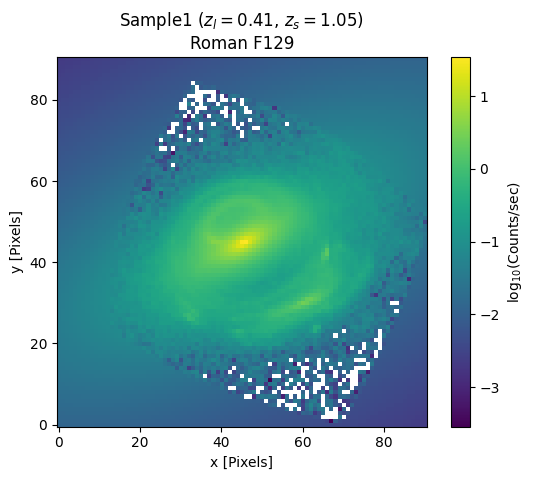

In [36]:
synth_1 = SyntheticImage(sample_1, band='F129', instrument=roman, fov_arcsec=10)
synth_1.plot()

Scene size: 10.01 arcsec, 91 pixels at pixel scale 0.11 arcsec/pix
Synthetic image calculation time: 0.108 s


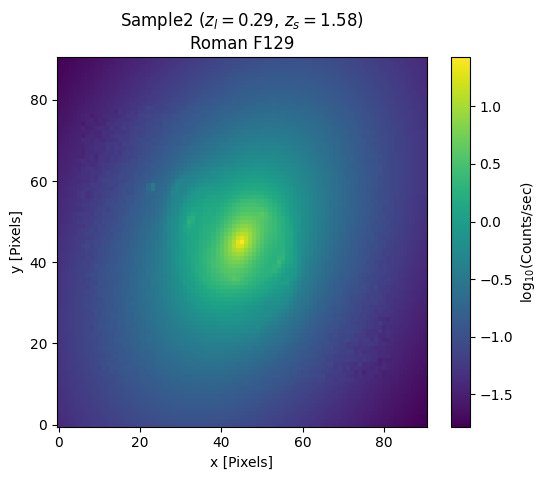

In [37]:
synth_2 = SyntheticImage(sample_2, band='F129', instrument=roman, fov_arcsec=10)
synth_2.plot()

Scene size: 10.01 arcsec, 91 pixels at pixel scale 0.11 arcsec/pix
Synthetic image calculation time: 0.367 s


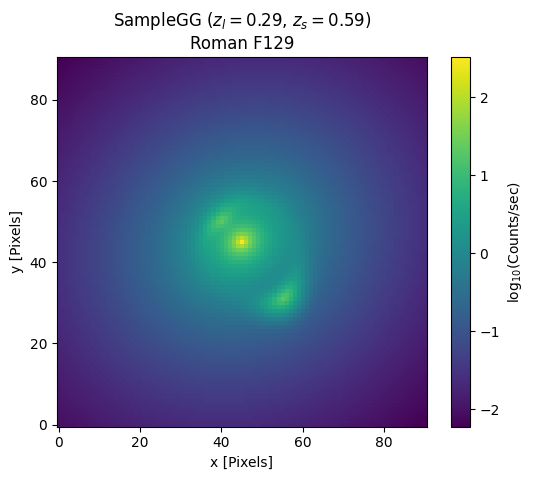

In [38]:
synth_gg = SyntheticImage(sample_gg, band='F129', instrument=roman, fov_arcsec=10)
synth_gg.plot()

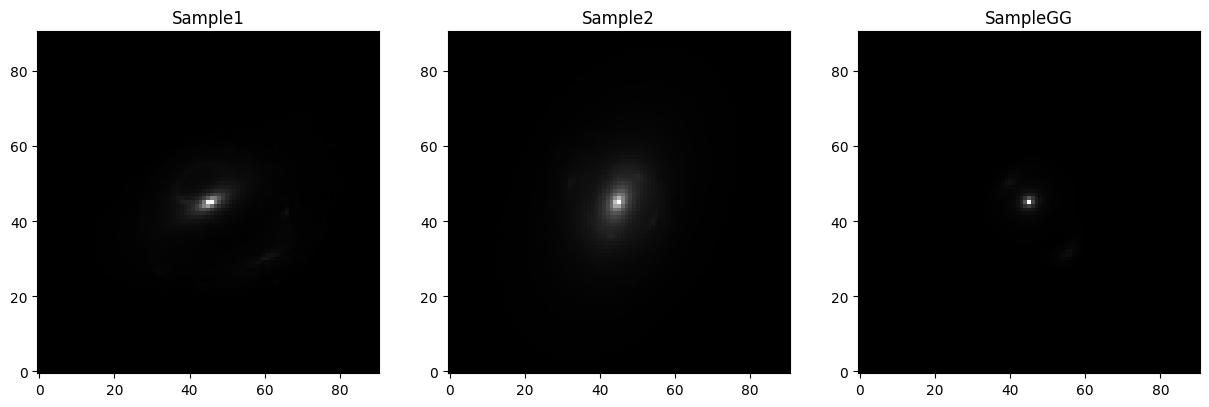

In [45]:
synths = [synth_1, synth_2, synth_gg]
images = [synth.image for synth in synths]
names = [synth.strong_lens.name for synth in synths]

_, ax = plt.subplots(1, len(images), figsize=(len(images) * 5, 5))
for i, img in enumerate(images):
    ax[i].imshow(img, origin='lower', cmap='gray')
    ax[i].set_title(f'{names[i]}')
plt.show()

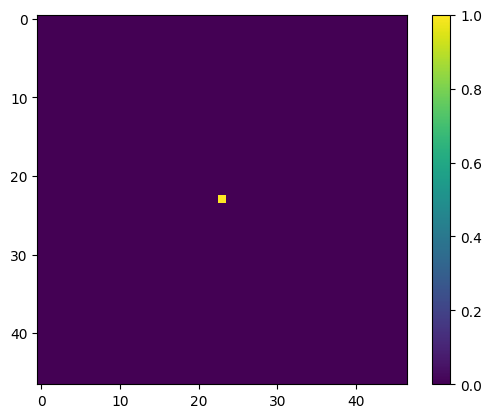

In [24]:
# make a PSF for these
psf = im1 * 0
cenpix = im1.shape[0] // 2
psf[cenpix, cenpix] = 1
sigma = 1
# psf = gaussian_filter(psf, sigma)

plt.imshow(psf)
plt.colorbar()
plt.show()

In [ ]:
# set up the image catalog
filenames = [names[i] + '.fits' for i in range(len(names))]

for i, f in enumerate(filenames):
    fits.writeto(f, )
fits.writeto(filenames[0], gaussian_filter(im1, sigma), overwrite=True)
fits.writeto(filenames[1], gaussian_filter(im2, sigma), overwrite=True)
base_rgc_filename = 'test_image_catalog'

dumb_existing_files = glob(f'{base_rgc_filename}*.fits')
for f in dumb_existing_files:
    os.remove(f)
    
catalog.make_image_catalog(filenames, psf, base_rgc_filename)

In [26]:
# make some metadata to describe an image for us to render
roman.n_pix = 500
coord = SkyCoord(270 * u.deg, 66 * u.deg)
meta = util.default_image_meta(coord=coord, filter_name='F087')
wcs.fill_in_parameters(meta, coord)
imwcs = wcs.get_wcs(meta, usecrds=False)

# make a table of sources for us to render
tab = table.Table()
cen = imwcs.toWorld(galsim.PositionD(roman.n_pix / 2, roman.n_pix / 2))
offsets = np.array([[-300, 300, -100, -200, 0, 0],
                    [0, 100, -200, -100, 0, -300]])
offsets = offsets * 0.1 / 60 / 60
tab['ra'] = util.skycoord(cen).ra.to(u.degree).value + offsets[0, :]
tab['dec'] = util.skycoord(cen).dec.to(u.degree).value + offsets[1, :]
tab['ident'] = np.arange(6) % 2  # alternate circles and rectangles
tab['rotate'] = np.arange(6) * 60
tab['shear_pa'] = (5 - np.arange(6)) * 60
tab['shear_ba'] = [0.5, 0.3, 0.9, 0.8, 1, 1]
tab['dilate'] = [0.5, 0.1, 0.9, 1.1, 2, 0.8]
tab['F087'] = [1e-7, 2e-7, 3e-7, 3e-7, 2e-7, 1e-7]
tab.meta['real_galaxy_catalog_filename'] = str(base_rgc_filename) + '.fits'

In [27]:
os.environ['STPSF_PATH'] = '/data/bwedig/STScI/stpsf-data'

In [28]:
# render the image
res = image.simulate(meta, tab, usecrds=False, psftype='galsim', level=2)

2026-02-09 11:26:25 WARNING  --usecrds is not set.  romanisim will not use reference files from CRDS.  The WCS may be incorrect and up-to-date calibration information will not be used.
2026-02-09 11:26:25 WARNING  No RNG set, constructing a new default RNG from default seed.
2026-02-09 11:26:25 INFO     Simulating filter F087...
2026-02-09 11:26:26 INFO     Creating PSF using galsim
2026-02-09 11:26:26 INFO     Creating PSF using galsim
2026-02-09 11:26:26 INFO     Creating PSF using galsim
2026-02-09 11:26:26 INFO     Creating PSF using galsim
2026-02-09 11:26:26 INFO     Adding 6 sources to image...
2026-02-09 11:26:26 WARNING  You requested fastpointsources, but the PSF and/or chromaticity are incompatible with this setting.  Disabling fastpointsources.
2026-02-09 11:26:27 INFO     Rendered 0 point sources in 8.85e-05 seconds
2026-02-09 11:26:27 INFO     Rendered 6 total sources in 0.305 seconds
2026-02-09 11:26:27 INFO     Apportioning electrons to resultants...
2026-02-09 11:26:29

In [29]:
# did we get all the flux?
totflux = np.sum(res[0].data - np.median(res[0].data))
expectedflux = (romanisim.bandpass.get_abflux('F087', int(meta['instrument']['detector'][3:])) * np.sum(tab['F087'])
                / parameters.reference_data['gain'])
assert np.abs(totflux / expectedflux - 1) < 0.1

# are there sources where there should be?
for r, d in zip(tab['ra'], tab['dec']):
    x, y = imwcs.toImage(r, d, units=galsim.degrees)
    x = int(x)
    y = int(y)
    assert res[0].data[y, x] > np.median(res[0].data) * 5
log.info('DMS228: Successfully added rendered sources from image input; '
            'sources are present and flux matches.')

2026-02-09 11:26:29 INFO     DMS228: Successfully added rendered sources from image input; sources are present and flux matches.


In [30]:
af = asdf.AsdfFile()
af.tree = {'im1': im1,
            'im2': im2,
            'psf': psf,
            'catalog': tab,
            'output': res[0].data,
            }
af.write_to('dms228.asdf')

In [31]:
# Read the ASDF file
af = asdf.open('dms228.asdf')
print('Keys:', list(af.tree.keys()))
print()
for key, value in af.tree.items():
    if hasattr(value, 'shape'):
        print(f'{key}: shape={value.shape}, dtype={value.dtype}')
    else:
        print(f'{key}: {type(value).__name__}')
        if key == 'catalog':
            print(value)

Keys: ['asdf_library', 'history', 'catalog', 'im1', 'im2', 'output', 'psf']

asdf_library: Software
history: dict
catalog: Table
        ra                dec        ident rotate shear_pa shear_ba dilate  F087
------------------ ----------------- ----- ------ -------- -------- ------ -----
 269.7850043417312 66.03285992231001     0      0      300      0.5    0.5 1e-07
 269.8016710083979 66.03563770008779     1     60      240      0.3    0.1 2e-07
269.79055989728676 66.02730436675445     0    120      180      0.9    0.9 3e-07
  269.787782119509 66.03008214453223     1    180      120      0.8    1.1 3e-07
269.79333767506455 66.03285992231001     0    240       60      1.0    2.0 2e-07
269.79333767506455 66.02452658897667     1    300        0      1.0    0.8 1e-07
im1: shape=(47, 47), dtype=float64
im2: shape=(47, 47), dtype=float64
output: shape=(500, 500), dtype=float32
psf: shape=(47, 47), dtype=float64


/tmp/ipykernel_4042459/1904292406.py:1: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(af['output']))


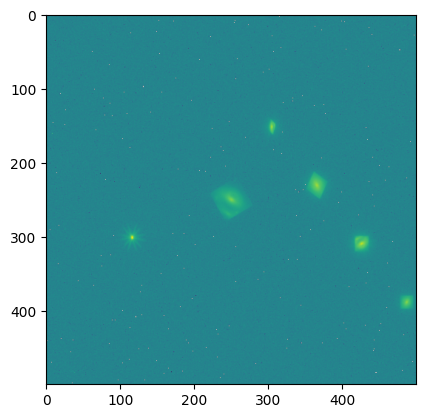

In [32]:
plt.imshow(np.log10(af['output']))
plt.show()